<a href="https://colab.research.google.com/github/aureguerrero/plantas/blob/main/Preparando_plantas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install rasterio
!pip intall affine
!pip install pyproj
!pip install pygeoj
!pip install geopandas

     |████████████████████████████████| 19.3 MB 1.3 MB/s 
ERROR: unknown command "intall" - maybe you meant "install"
     |████████████████████████████████| 6.3 MB 5.7 MB/s 
  Created wheel for pygeoj: filename=PyGeoj-1.0.0-py3-none-any.whl size=10347 sha256=bbcfb05f187bff75e781730ec3b0c15edd6442883cb5975958b520b5f1dd0cbe
  Stored in directory: /root/.cache/pip/wheels/16/4b/11/0803a9faf4f6c123ca96cda96ef3a01a1b82a0671417dcedaf
Successfully built pygeoj
     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 15.4 MB 40.1 MB/s 


In [2]:
import gdal
import rasterio
import numpy as np
from affine import Affine
from pyproj import Proj, transform
import pygeoj
import geopandas as gpd
import matplotlib.pyplot as plt
import cv2
import shutil
import random as rd
import os

# Del Repositor

In [3]:
!git clone https://github.com/aureguerrero/plantas.git

Cloning into 'plantas'...
remote: Enumerating objects: 840, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 840 (delta 173), reused 228 (delta 173), pack-reused 612
Receiving objects: 100% (840/840), 128.30 MiB | 27.62 MiB/s, done.
Resolving deltas: 100% (321/321), done.
Checking out files: 100% (986/986), done.


In [4]:
%cd plantas

/content/plantas


In [6]:
%mkdir conj_ima_new
%mkdir archivos_new

mkdir: cannot create directory ‘conj_ima_new’: File exists


## Pasar de json a csv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1375, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.


(1372, 2000, 3)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


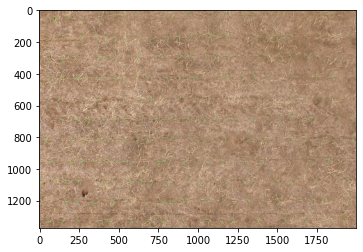

In [9]:
archivos=[_ for _ in os.listdir('/content/plantas/archivos_new') if _.endswith('.tif')]


for nombre in archivos:
  nombre=nombre[:-4]
  json=[_ for _ in os.listdir('/content/plantas/archivos_new/') if _.endswith('.geojson') and _.startswith(nombre)]
  df = gpd.read_file('/content/plantas/archivos_new/'+json[0])
  fname = '/content/plantas/archivos_new/'+nombre+'.tif'

  # Read raster
  with rasterio.open(fname) as r:
      T0 = r.transform  # upper-left pixel corner affine transform
      p1 = Proj(r.crs)
      A = r.read()
  plantas={'id':[],'coord':[],'minx':[],'maxx':[],'miny':[],'maxy':[]}
  for i in range(0,len(df)):
    a=df['geometry'][i]
    points = []
    for polygon in a:
      points.extend(polygon.exterior.coords[:-1])
    points =np.array([point for polygon in a for point in polygon.exterior.coords[:-1]])
    points[:,0]=np.int16((points[:,0]-T0[2])/T0[0])
    points[:,1]=np.int16((points[:,1]-T0[5])/T0[4])
    minx, maxx, miny, maxy=np.int16(np.min(points[:,0])), np.int16(np.max(points[:,0])),np.int16(np.min(points[:,1])), np.int16(np.max(points[:,1]))
    #plantas.append({'coord':points,'extrem':[[minx,maxx],[miny,maxy]]})
    plantas['id'].append(i), plantas['coord'].append(points), plantas['minx'].append(minx),plantas['maxx'].append(maxx),plantas['miny'].append(miny),plantas['maxy'].append(maxy)
  image=gdal.Open(fname).ReadAsArray().transpose([1,2,0])
  print(np.shape(image))
  
  n=[np.shape(image)[0]//512,np.shape(image)[1]//512]
  for i in range(0,n[0]):
    for j in range(0,n[1]):
      recorte=image[i*512:(i+1)*512,j*512:(j+1)*512,:]
      cv2.imwrite("/content/plantas/conj_ima_new/"+nombre+"_"+str(i)+"_"+str(j)+".png",recorte)
      pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
      np.save("/content/plantas/conj_ima_new/"+nombre+"_"+str(i)+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,i*512] for t in pos])
    recorte=image[i*512:(i+1)*512,np.shape(image)[1]-512:np.shape(image)[1],:]
    cv2.imwrite("/content/plantas/conj_ima_new/"+nombre+"_"+str(i)+"_"+str(n[1])+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >i*512), np.where(np.array(plantas['maxy']) <(i+1)*512)),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
    np.save("/content/plantas/conj_ima_new/"+nombre+"_"+str(i)+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,i*512] for t in pos])

  for j in range(0,n[1]):
    recorte=image[np.shape(image)[0]-512:np.shape(image)[0],j*512:(j+1)*512,:]
    cv2.imwrite("/content/plantas/conj_ima_new/"+nombre+"_"+str(n[0])+"_"+str(j)+".png",recorte)
    pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >j*512)),np.where(np.array(plantas['maxx']) <(j+1)*512))
    np.save("/content/plantas/conj_ima_new/"+nombre+"_"+str(n[0])+"_"+str(j)+".npy",[plantas['coord'][t]-[j*512,np.shape(image)[0]-512] for t in pos])

  recorte=image[np.shape(image)[0]-512:np.shape(image)[0],np.shape(image)[1]-512:np.shape(image)[1],:]
  cv2.imwrite("/content/plantas/conj_ima_new/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".png",recorte)
  pos=np.intersect1d(np.intersect1d(np.intersect1d(np.where(np.array(plantas['miny']) >np.shape(image)[0]-512), np.where(np.array(plantas['maxy']) <np.shape(image)[0])),np.where(np.array(plantas['minx']) >np.shape(image)[1]-512)),np.where(np.array(plantas['maxx']) <np.shape(image)[1]))
  np.save("/content/plantas/conj_ima_new/"+nombre+"_"+str(n[0])+"_"+str(n[1])+".npy",[plantas['coord'][t]-[np.shape(image)[1]-512,np.shape(image)[0]-512] for t in pos])



In [16]:
from numpy.ma.core import sort
pos=[_ for _ in sort(os.listdir('/content/plantas/conj_ima_new')) if _.endswith('npy')]
rd.shuffle(pos)
split = int(0.8 *len(pos))
train=pos[-split:]
test=pos[:-split]


In [12]:
%mkdir conj_ima_new/test
%mkdir conj_ima_new/train

In [18]:
for i in train:
  shutil.copy("/content/plantas/conj_ima_new/"+i[:-3]+'png',"/content/plantas/conj_ima_new/train/"+i[:-3]+'png')
  shutil.copy("/content/plantas/conj_ima/"+i,"/content/plantas/conj_ima_new/train/"+i)
for i in test:
  shutil.copy("/content/plantas/conj_ima_new/"+i[:-3]+'png',"/content/plantas/conj_ima_new/test/"+i[:-3]+'png')
  shutil.copy("/content/plantas/conj_ima/"+i,"/content/plantas/conj_ima_new/test/"+i)


In [14]:
list_test_npy=np.load('list_test_npy.npy')
list_train_npy=np.load('list_train_npy.npy')

In [29]:
list_train_png=[_ for _ in os.listdir('/content/plantas/train/') if _.endswith('.png')]
np.save('list_train_png.npy',list_train_png)
list_train_npy=[_ for _ in os.listdir('/content/plantas/train/') if _.endswith('.npy')]
np.save('list_train_npy.npy',list_train_npy)

In [32]:
at=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
at_new=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_test_npy:
  a=np.load("/content/plantas/test/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/test/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    at.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
for i in test:
  a=np.load("/content/plantas/conj_ima_new/test/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/conj_ima_new/test/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    at.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
    at_new.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])



np.savetxt("/content/plantas/conj_ima_new/test/numpy_test.csv", at, delimiter =",",fmt ='% s')
np.savetxt("/content/plantas/conj_ima_new/test/numpy_test_new.csv", at_new, delimiter =",",fmt ='% s')

In [33]:
at=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
at_new=[['filename', 'file_size', 'file_attributes', 'region_count', 'region_id', 'region_shape_attributes', 'region_attributes']]
for i in list_train_npy:
  a=np.load("/content/plantas/train/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/train/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    at.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])

for i in train:
  a=np.load("/content/plantas/conj_ima_new/train/"+i, allow_pickle=True)
  filename=i[:-3]+'png'
  file_size=str(os.path.getsize(r'/content/plantas/conj_ima_new/train/'+i[:-3]+'png'))
  file_attributes='"{}"'
  region_count=str(len(a))
  for j in range(0,len(a)):
    region_id=str(j)
    region_shape_attributes='"{""name"":""polygon"",""all_points_x"":['+','.join(str(np.int16(x)) for x in a[j][:,0])+'],""all_points_y"":['+','.join(str(np.int16(x)) for x in a[j][:,1])+']}"'
    region_attributes='""obj"":""planta""'
    at.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])
    at_new.append([filename, file_size, file_attributes, region_count, region_id, region_shape_attributes, region_attributes])



np.savetxt("/content/plantas/conj_ima_new/train/numpy_train.csv", at, delimiter =",",fmt ='% s')
np.savetxt("/content/plantas/conj_ima_new/train/numpy_train_new.csv", at_new, delimiter =",",fmt ='% s')

# Pasar de json a txt

In [34]:
%mkdir /content/plantas/conj_ima_new/test/labels
%mkdir /content/plantas/conj_ima_new/train/labels

In [35]:
import numpy as np
import os
fileDir = "/content/plantas/conj_ima_new/"
list_train_npy=[_ for _ in os.listdir(fileDir+'train/') if _.endswith(r".npy")]

for i in train:
  a=np.load(fileDir+'train/'+i,allow_pickle=True)
  np.savetxt(fileDir+'train/labels/'+i[:-4]+'.txt',[str(0)+ ' '+str("{0:.6f}".format(np.mean(a[j][0,:]/511)))+' '+str("{0:.6f}".format(np.mean(a[j][1,:]/511)))+' '+str("{0:.6f}".format((np.max(a[j][0,:])-np.min(a[j][0,:]))/511.))+' '+str("{0:.6f}".format((np.max(a[j][1,:])-np.min(a[j][1,:]))/511.)) for j in range(0,len(a))],delimiter =",",fmt='%s')

list_test_npy=[_ for _ in os.listdir(fileDir+'test/') if _.endswith(r".npy")]

for i in test:
  a=np.load(fileDir+'test/'+i,allow_pickle=True)
  np.savetxt(fileDir+'test/labels/'+i[:-4]+'.txt',[str(0)+ ' '+str("{0:.6f}".format(np.mean(a[j][0,:]/511)))+' '+str("{0:.6f}".format(np.mean(a[j][1,:]/511)))+' '+str("{0:.6f}".format((np.max(a[j][0,:])-np.min(a[j][0,:]))/511.))+' '+str("{0:.6f}".format((np.max(a[j][1,:])-np.min(a[j][1,:]))/511.)) for j in range(0,len(a))],delimiter =",",fmt='%s')

#Pasar a xml

In [36]:
%mkdir /content/plantas/conj_ima_new/test/xml
%mkdir /content/plantas/conj_ima_new/train/xml

In [50]:
import os
import re
from PIL import Image

folder_holding_files = '/content/plantas/conj_ima_new/test/'



for image_name in [_ for _ in os.listdir(folder_holding_files) if _.endswith('.png')]:
  orig_img = Image.open(folder_holding_files+image_name) # open the image
  image_width = orig_img.width
  image_height = orig_img.height
  # Start the XML file
  with open(folder_holding_files+'xml/'+image_name[:-3]+'xml', 'w') as f:
    f.write('<annotation>\n')
    f.write('\t<folder>XML</folder>\n')
    f.write('\t<filename>' + image_name + '</filename>\n')
    f.write('\t<path>' + folder_holding_files + image_name + '</path>\n')
    f.write('\t<source>\n')
    f.write('\t\t<database>Unknown</database>\n')
    f.write('\t</source>\n')
    f.write('\t<size>\n')
    f.write('\t\t<width>' + str(image_width) + '</width>\n')
    f.write('\t\t<height>' + str(image_height) + '</height>\n')
    f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
    f.write('\t</size>\n')
    f.write('\t<segmented>0</segmented>\n')
    a=np.load(folder_holding_files+image_name[:-3]+'npy',allow_pickle=True)
    for j in range(0,len(a)):
      # write each object to the file
      f.write('\t<object>\n')
      f.write('\t\t<name>' + 'planta' + '</name>\n')
      f.write('\t\t<pose>Unspecified</pose>\n')
      f.write('\t\t<truncated>0</truncated>\n')
      f.write('\t\t<difficult>0</difficult>\n')
      f.write('\t\t<bndbox>\n')
      f.write('\t\t\t<xmin>' + str(np.int64(np.min(a[j],0)[0])) + '</xmin>\n')
      f.write('\t\t\t<ymin>' + str(np.int64(np.min(a[j],0)[1])) + '</ymin>\n')
      f.write('\t\t\t<xmax>' + str(np.int64(np.max(a[j],0)[0])) + '</xmax>\n')
      f.write('\t\t\t<ymax>' + str(np.int64(np.max(a[j],0)[1])) + '</ymax>\n')
      f.write('\t\t</bndbox>\n')
      f.write('\t</object>\n')

        # Close the annotation tag once all the objects have been written to the file
    f.write('</annotation>\n')
    f.close() # Close the file


folder_holding_files = '/content/plantas/conj_ima_new/train/'



for image_name in [_ for _ in os.listdir(folder_holding_files) if _.endswith('.png')]:
  orig_img = Image.open(folder_holding_files+image_name) # open the image
  image_width = orig_img.width
  image_height = orig_img.height
  # Start the XML file
  with open(folder_holding_files+'xml/'+image_name[:-3]+'xml', 'w') as f:
    f.write('<annotation>\n')
    f.write('\t<folder>XML</folder>\n')
    f.write('\t<filename>' + image_name + '</filename>\n')
    f.write('\t<path>' + folder_holding_files + image_name + '</path>\n')
    f.write('\t<source>\n')
    f.write('\t\t<database>Unknown</database>\n')
    f.write('\t</source>\n')
    f.write('\t<size>\n')
    f.write('\t\t<width>' + str(image_width) + '</width>\n')
    f.write('\t\t<height>' + str(image_height) + '</height>\n')
    f.write('\t\t<depth>3</depth>\n') # assuming a 3 channel color image (RGB)
    f.write('\t</size>\n')
    f.write('\t<segmented>0</segmented>\n')
    a=np.load(folder_holding_files+image_name[:-3]+'npy',allow_pickle=True)
    for j in range(0,len(a)):
      # write each object to the file
      f.write('\t<object>\n')
      f.write('\t\t<name>' + 'planta' + '</name>\n')
      f.write('\t\t<pose>Unspecified</pose>\n')
      f.write('\t\t<truncated>0</truncated>\n')
      f.write('\t\t<difficult>0</difficult>\n')
      f.write('\t\t<bndbox>\n')
      f.write('\t\t\t<xmin>' + str(np.int64(np.min(a[j],0)[0])) + '</xmin>\n')
      f.write('\t\t\t<ymin>' + str(np.int64(np.min(a[j],0)[1])) + '</ymin>\n')
      f.write('\t\t\t<xmax>' + str(np.int64(np.max(a[j],0)[0])) + '</xmax>\n')
      f.write('\t\t\t<ymax>' + str(np.int64(np.max(a[j],0)[1])) + '</ymax>\n')
      f.write('\t\t</bndbox>\n')
      f.write('\t</object>\n')

        # Close the annotation tag once all the objects have been written to the file
    f.write('</annotation>\n')
    f.close() # Close the file


In [60]:
!zip -r conj_ima_new.zip /content/plantas/conj_ima_new/

updating: content/plantas/conj_ima_new/ (stored 0%)
  adding: content/plantas/conj_ima_new/dji-0002crop_0_1.png (deflated 6%)
  adding: content/plantas/conj_ima_new/dji-0001crop_0_2.png (deflated 7%)
  adding: content/plantas/conj_ima_new/dji-0002crop_2_1.npy (deflated 89%)
  adding: content/plantas/conj_ima_new/test/ (stored 0%)
  adding: content/plantas/conj_ima_new/test/dji-0002crop_1_2.png (deflated 7%)
  adding: content/plantas/conj_ima_new/test/xmldji-0001crop_2_1.xml (deflated 89%)
  adding: content/plantas/conj_ima_new/test/xml/ (stored 0%)
  adding: content/plantas/conj_ima_new/test/xml/dji-0001crop_1_2.xml (deflated 89%)
  adding: content/plantas/conj_ima_new/test/xml/dji-0002crop_1_2.xml (deflated 86%)
  adding: content/plantas/conj_ima_new/test/xml/dji-0001crop_2_1.xml (deflated 89%)
  adding: content/plantas/conj_ima_new/test/xml/dji-0002crop_2_0.xml (deflated 89%)
  adding: content/plantas/conj_ima_new/test/xml/dji-0001crop_2_3.xml (deflated 89%)
  adding: content/plantas